In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import rioxarray
from rasterio.enums import Resampling

import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf

import scipy.stats as stats
from scipy.stats import linregress

from sklearn.linear_model import LinearRegression

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

In [2]:
yy_s, yy_e = 2002, 2023
years_num = yy_e - yy_s + 1

npix = 2
acf = 'mar'
cor = 'pearson'

QC_method = 'QCv1_Flag1'

In [3]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

In [4]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

# update name of REGIONS geopandas
REGIONS = REGIONS.rename(columns={"reg_name": "Region"})
REGIONS['Region'] = REGIONS['Region'].replace('Emilia Romagna', 'Emilia-Romagna')

In [5]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite')

In [6]:
sat_product = f'ITALY_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc' # CMORPH
# sat_product = f'ITALY_DOWN_ERA5_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc' # ERA5
# sat_product = f'ITALY_DOWN_GSMaP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc' # GSMaP
# sat_product = f'ITALY_DOWN_MSWEP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc' # MSWEP
# sat_product = f'ITALY_DOWN_IMERG_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc' # IMERG
# sat_product = f'ITALY_DOWN_CHIRPS_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc' # CHIRPS

data_dir = os.path.join(dir_base, '5_DOWN', sat_product)

In [7]:
DATA = xr.open_dataset(data_dir)

if DATA.lat[0] > DATA.lat[-1]:
    DATA = DATA.sortby("lat")

DATA = DATA.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lats = DATA.lat
lons = DATA.lon
lon2d, lat2d = np.meshgrid(lons, lats)

Sat_year = DATA.year.values

NYs = DATA.NYs.values
CYs = DATA.CYs.values
WYs = DATA.WYs.values

NYd = DATA.NYd.values
CYd = DATA.CYd.values
WYd = DATA.WYd.values

Mev_d = DATA.Mev_d.values 

ntim, nlat, nlon = NYd.shape

In [8]:
# DEM = rioxarray.open_rasterio("/media/arturo/T9/Data/shapes/Europa/Italy/DEM/dtm_elev_30m_Italy_v2.tif")
# DEM = DEM.squeeze(drop=True) 

# target_grid = xr.Dataset(
#     coords={
#         "lon": DATA.lon,
#         "lat": DATA.lat
#     }
# )

# target_grid = target_grid.rio.write_crs("EPSG:4326")  # WGS84
# target_grid = target_grid.rename({"lon": "x", "lat": "y"})  
# target_grid = target_grid.rio.set_spatial_dims(x_dim="x", y_dim="y")

# DEM_on_GRID = DEM.rio.reproject_match(
#     target_grid,
#     resampling=Resampling.bilinear)

# DEM_on_GRID = DEM_on_GRID.rename({"x": "lon", "y": "lat"})

# DEM_on_GRID = DEM_on_GRID.where(DEM_on_GRID != -9999.9, np.nan)
# DEM_on_GRID = DEM_on_GRID.clip(min=0)

# plt.pcolormesh(lon2d, lat2d, DEM_on_GRID)
# plt.colorbar()

In [9]:
obs_base = os.path.join('/','media','arturo','T9','Data','Italy', 'stations', 'Italy_raingauges', 'QC_MIX')

In [10]:
METADATA = pd.read_csv(os.path.join(obs_base, 'METADATA', 'METADATA_INTENSE_UPDATE.csv'))
METADATA["Lat"] = np.round(METADATA["Lat"], 6)
METADATA["Lon"] = np.round(METADATA["Lon"], 6)
METADATA.head(2)

,Unnamed: 0,File,ISO,Region,Code,Name,Elevation,Or_EPSG,CRS_E,CRS_N,...,Source,TimeZon,Elevation.1,Orig_EPSG,Year_Start,Year_End,INTENSE_Resp,TimeZone,elevation_DEM,Elevation_update
0,0,IT-322_AA_6535_0060_QCv1.csv,IT-322,Alto-Adige,AA_6535,VANDOIESDISOPRA,746.0,32632.0,710057.0,5187849.0,...,Alto-Adige,UTC,NaN,NaN,NaN,NaN,NaN,NaN,745.9,746.0
1,1,IT-322_AA_5650_0060_QCv1.csv,IT-322,Alto-Adige,AA_5650,SELVADEIMOLINI,1141.0,32632.0,718972.0,5196967.0,...,Alto-Adige,UTC,NaN,NaN,NaN,NaN,NaN,NaN,1140.0,1141.0


In [11]:
def ISIMIP_QM(obs, sat):
    """
    Aplica la corrección de sesgo usando ISIMIP QM (Quantile Mapping).
    """
    # Cuantiles de los datos
    quantiles = np.linspace(0, 1, len(obs))
    
    # Ajuste de cuantiles
    obs_quantiles = np.nanquantile(obs, quantiles)
    sat_quantiles = np.nanquantile(sat, quantiles)
    
    # Aplicar ajuste a los datos satelitales
    corrected_sat = np.interp(sat, sat_quantiles, obs_quantiles)
    
    return corrected_sat

In [12]:
frac = 0.8

Q_80 = METADATA.sample(frac=frac, random_state=42)
Q_80 = Q_80.reset_index(drop=True)

Q_20 = METADATA.drop(Q_80.index)
Q_20 = Q_20.reset_index(drop=True)

print(f'Number of Stations: {len(METADATA)}')
print(f'80% DataFrame: {len(Q_80)}')
print(f'20% DataFrame: {len(Q_20)}')

Number of Stations: 2981
80% DataFrame: 2385
20% DataFrame: 596


In [13]:
N_obs, C_obs, W_obs = [], [], []
for nn in range(len(Q_80)):#len(Q_80)
    file_ = Q_80.File[nn]
    statistic = pd.read_csv(os.path.join(obs_base, 'DATA_1dy','statistics',QC_method,Q_80.ISO[nn],Q_80.File[nn]))
    statistic = statistic[statistic['Year']>2002].reset_index(drop=True)
    N_obs.extend(statistic.N.values)
    C_obs.extend(statistic.C.values)
    W_obs.extend(statistic.W.values)

In [ ]:
NYd_corrected = ISIMIP_QM(N_obs, NYd.flatten())
CYd_corrected = ISIMIP_QM(C_obs, CYd.flatten())
WYd_corrected = ISIMIP_QM(W_obs, WYd.flatten())

In [15]:
NYd_corrected = NYd_corrected.reshape(ntim, nlat, nlon)
CYd_corrected = CYd_corrected.reshape(ntim, nlat, nlon)
WYd_corrected = WYd_corrected.reshape(ntim, nlat, nlon)

In [16]:
WYd_corrected = np.where(WYd_corrected>2.5,np.nan,WYd_corrected)

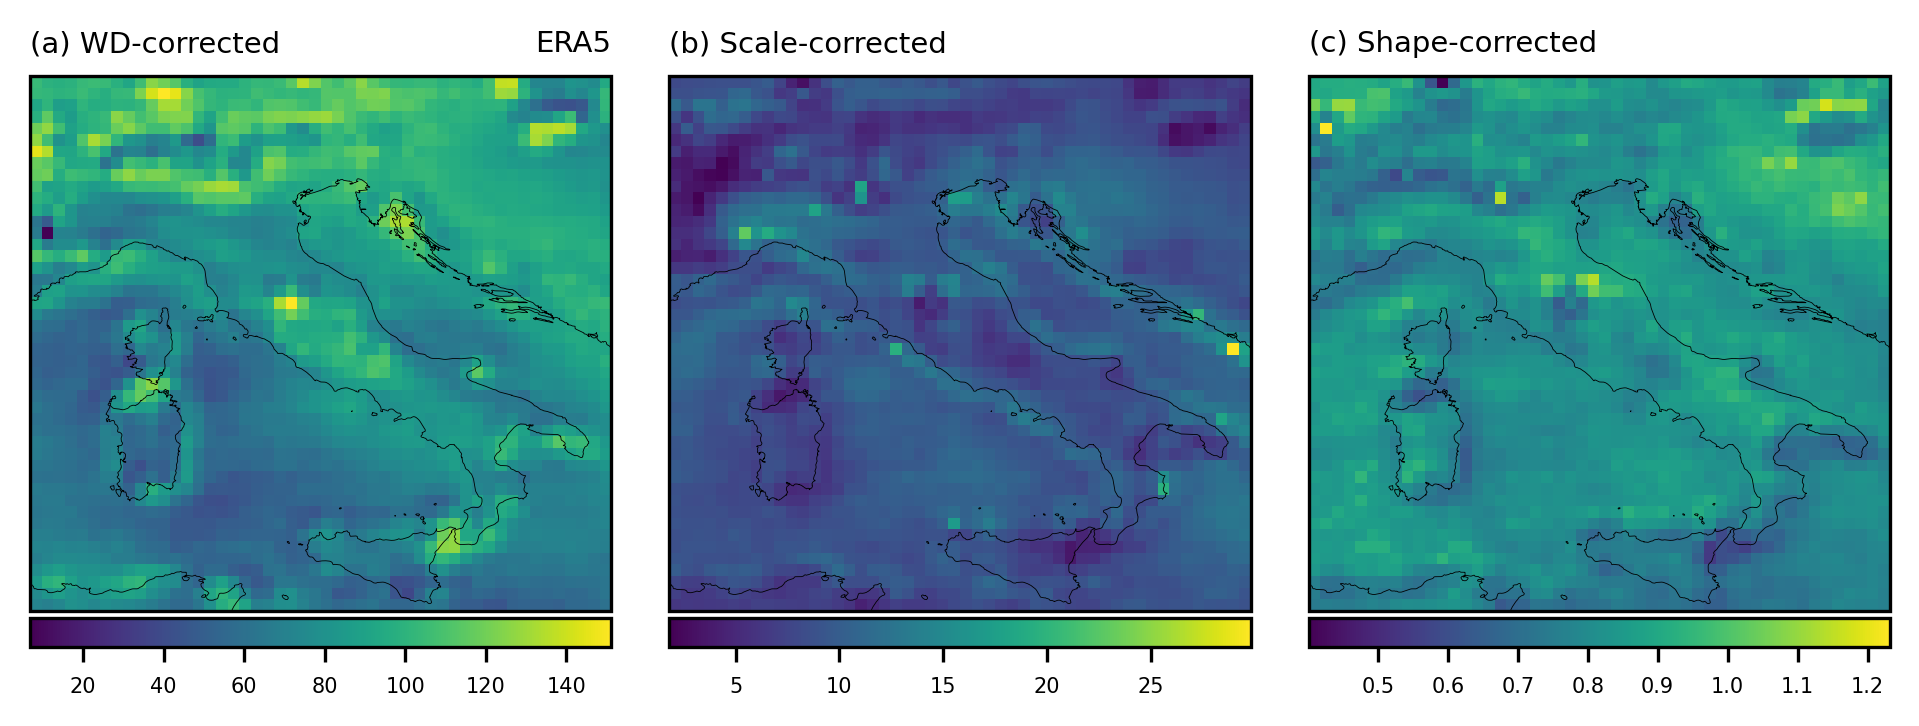

In [17]:
N_norm = None
C_norm = None
W_norm = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(NYd_corrected,axis=0), norm=N_norm)

ax1.set_title(f'(a) WD-corrected', fontsize=7, loc='left')
ax1.set_title(f'ERA5', fontsize=7, loc='right')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(CYd_corrected,axis=0), norm=C_norm)

ax1.set_title(f'(b) Scale-corrected', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(WYd_corrected,axis=0), norm=W_norm)

ax1.set_title(f'(c) Shape-corrected', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.1)


ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [18]:
DOWN_corrected = xr.Dataset(
    data_vars={
        "NYs": (("year","lat","lon"), NYs),
        "CYs": (("year","lat","lon"), CYs),
        "WYs": (("year","lat","lon"), WYs),
        "NYd": (("year","lat","lon"), NYd_corrected),
        "CYd": (("year","lat","lon"), CYd_corrected),
        "WYd": (("year","lat","lon"), WYd_corrected),
    },
    coords={
        'year': Sat_year, 
        'lat': lats, 
        'lon': lons
    },
    attrs=dict(description=f"Weibull parameters corrected applying ISIMIP_QM method using 80% of stations in Italy",)
)

DOWN_corrected.NYs.attrs["units"] = "# days"
DOWN_corrected.NYs.attrs["long_name"] = "Ensemble Satellite Number of Wet Days"
DOWN_corrected.NYs.attrs["origname"] = "Down Wet Days"

DOWN_corrected.CYs.attrs["units"] = "nondimensional"
DOWN_corrected.CYs.attrs["long_name"] = "Ensemble Satellite Scale Parameter"
DOWN_corrected.CYs.attrs["origname"] = "Down Scale"

DOWN_corrected.WYs.attrs["units"] = "nondimensional"
DOWN_corrected.WYs.attrs["long_name"] = "Ensemble Satellite Shape Parameter"
DOWN_corrected.WYs.attrs["origname"] = "Down Shape"

DOWN_corrected.NYd.attrs["units"] = "# days"
DOWN_corrected.NYd.attrs["long_name"] = "Corrected Ensemble Downscaled Number of Wet Days"
DOWN_corrected.NYd.attrs["origname"] = "Down Wet Days"

DOWN_corrected.CYd.attrs["units"] = "nondimensional"
DOWN_corrected.CYd.attrs["long_name"] = "Corrected Ensemble Downscaled Scale Parameter"
DOWN_corrected.CYd.attrs["origname"] = "Down Scale"

DOWN_corrected.WYd.attrs["units"] = "nondimensional"
DOWN_corrected.WYd.attrs["long_name"] = "Corrected Ensemble Downscaled Shape Parameter"
DOWN_corrected.WYd.attrs["origname"] = "Down Shape"

DOWN_corrected.lat.attrs["units"] = "degrees_north"
DOWN_corrected.lat.attrs["long_name"] = "Latitude"

DOWN_corrected.lon.attrs["units"] = "degrees_east"
DOWN_corrected.lon.attrs["long_name"] = "Longitude"

In [19]:
PRE_out = os.path.join(os.path.join(dir_base, '6_DOWN_corrected', sat_product))
print(f'Export as: {PRE_out}')
DOWN_corrected.to_netcdf(PRE_out)

Export as: /media/arturo/T9/Data/Italy/Satellite/6_DOWN_corrected/ITALY_DOWN_CMORPH_3h_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc


In [20]:
Tr = [5.,  10.,  20.,  50., 100., 200.]
Fi = 1 - 1/np.array(Tr)

x0 = np.nanmean(CYd_corrected)
DOWN_Q_corrected = ART_down.pre_quantiles_array(
                        NYd_corrected, 
                        CYd_corrected, 
                        WYd_corrected, 
                        Tr, 
                        lats, lons, 
                        1)

DOWN_Q_corrected_50 = DOWN_Q_corrected[3,:,:]

In [21]:
DOWN_Q_corrected_50[DOWN_Q_corrected_50>500]=np.nan

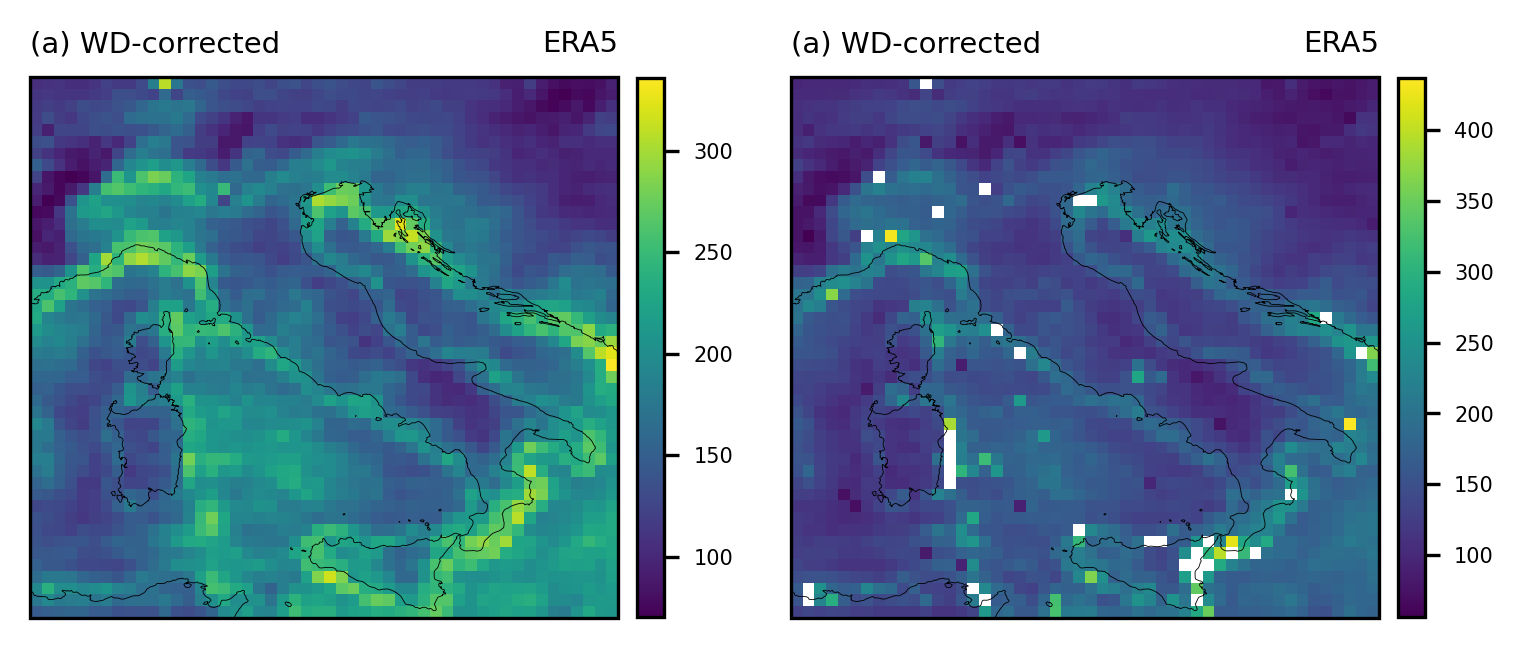

In [22]:
N_norm = None
C_norm = None
W_norm = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.pcolormesh(lon2d, lat2d, Mev_d[3,:,:], norm=N_norm)

ax1.set_title(f'(a) WD-corrected', fontsize=7, loc='left')
ax1.set_title(f'ERA5', fontsize=7, loc='right')

cbar = plt.colorbar(a1, ticks= None, orientation='vertical', pad=0.03, fraction=0.0425)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.pcolormesh(lon2d, lat2d, DOWN_Q_corrected_50, norm=N_norm)

ax1.set_title(f'(a) WD-corrected', fontsize=7, loc='left')
ax1.set_title(f'ERA5', fontsize=7, loc='right')

cbar = plt.colorbar(a1, ticks= None, orientation='vertical', pad=0.03, fraction=0.0425)
cbar.ax.tick_params(labelsize=5)


ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [23]:
ISO_names = pd.read_csv(os.path.join('/','media','arturo','T9','Data','Italy', 'stations', 'Italy_raingauges', 'ISO_IT_REGION_EN.csv'))
ISO_names["ISO_num"] = ISO_names["ISO"].str.split("-").str[1].astype(int)
ISO_names = ISO_names.sort_values("ISO_num").drop(columns="ISO_num").reset_index(drop=True)
ISO_names.head(3)

,Region,ISO
0,Piedmont,IT-210
1,Aosta Valley,IT-230
2,Lombardy,IT-250


## Relative Errors in comparison with 20%

In [ ]:
def export_STATISTICS(Q_20, NYd_input, CYd_input, WYd_input, lat2d_in, lon2d_in):
    diccionario_OBS_WN = {}
    diccionario_OBS_WC = {}
    diccionario_OBS_WW = {}

    diccionario_SAT_WN = {}
    diccionario_SAT_WC = {}
    diccionario_SAT_WW = {}

    diccionario_RE = {}
    diccionario_LAT = {}
    diccionario_LON = {}
    diccionario_ELEV = {}

    diccionario_Qobs = {}
    diccionario_Qest = {}

    for rr in range(len(ISO_names)):
        region_ISO = ISO_names.iloc[rr]['ISO']
        region_label = ISO_names[ISO_names['ISO']==region_ISO]

        # print(f'{rr+1}: {region_label['Region'].values[0]} ({region_ISO})')

        METADATA_clear = Q_20[Q_20['ISO']==region_ISO].reset_index(inplace=False)

        SAT_WN, SAT_WC, SAT_WW = [], [], []
        OBS_WN, OBS_WC, OBS_WW = [], [], []
        LAT, LON, RE_50, ELEV = [], [], [], []
        Qobs, Qest = [], []
        for nn in range(len(METADATA_clear)):#len(METADATA_clear)
            filename = f'{METADATA_clear['File'].values[nn]}'
            lat_obs = METADATA_clear['Lat'][nn]
            lon_obs = METADATA_clear['Lon'][nn]
            elev_obs = METADATA_clear['Elevation_update'][nn]

            OBS_pd = pd.read_csv(os.path.join(obs_base, 'DATA_1dy', 'statistics', QC_method, region_ISO, filename))
            OBS_pd = OBS_pd[(OBS_pd['Year']>=2002)&(OBS_pd['Year']<=2023)].reset_index(drop=True)
            if len(OBS_pd) == 0:
                continue

            else:
                OBS_N = OBS_pd['N'].values
                OBS_C = OBS_pd['C'].values
                OBS_W = OBS_pd['W'].values
                OBS_Y = OBS_pd['Year'].values

                mask = ~np.isnan(OBS_N)

                OBS_N = OBS_N[mask]
                OBS_C = OBS_C[mask]
                OBS_W = OBS_W[mask]
                OBS_Y = OBS_Y[mask]

                if len(OBS_Y) >= 8: # greather than 8 years

                    x0 = np.nanmean(OBS_C)
                    OBS_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, OBS_N, OBS_C, OBS_W, thresh=1)
                    OBS_Q2 = np.where(flag, OBS_Q, np.nan)

                    distances = ART_pre.haversine(lat2d_in, lon2d_in, lat_obs, lon_obs)
                    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
                    Sat_NYd_ = NYd_input[:,min_index[0],min_index[1]]
                    Sat_CYd_ = CYd_input[:,min_index[0],min_index[1]]
                    Sat_WYd_ = WYd_input[:,min_index[0],min_index[1]]

                    Sat_pd = pd.DataFrame({'Year':Sat_year, 'N':Sat_NYd_, 'C':Sat_CYd_, 'W':Sat_WYd_})
                    Sat_pd_filtered = Sat_pd[Sat_pd['Year'].isin(OBS_pd['Year'])].reset_index()

                    SAT_N = Sat_pd_filtered['N'].values
                    SAT_C = Sat_pd_filtered['C'].values
                    SAT_W = Sat_pd_filtered['W'].values
                    SAT_Y = Sat_pd_filtered['Year'].values

                    SAT_N = SAT_N[mask]
                    SAT_C = SAT_C[mask]
                    SAT_W = SAT_W[mask]
                    SAT_Y = SAT_Y[mask]

                    if len(OBS_Y) != len(SAT_Y):
                        print('ERROR')
                        sys.exit()
                    else:

                        OBS_WN.extend(OBS_N)
                        OBS_WC.extend(OBS_C)
                        OBS_WW.extend(OBS_W)

                        SAT_WN.extend(SAT_N)
                        SAT_WC.extend(SAT_C)
                        SAT_WW.extend(SAT_W)

                        x0 = np.nanmean(SAT_C)
                        SAT_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, SAT_N, SAT_C, SAT_W, thresh=1)
                        SAT_Q2 = np.where(flag, SAT_Q, np.nan)

                    relative_e_50 = (SAT_Q2[3] - OBS_Q2[3])/OBS_Q2[3]

                    LAT.append(float(lat_obs))
                    LON.append(float(lon_obs))
                    RE_50.append(float(relative_e_50))
                    ELEV.append(float(elev_obs))
                    Qobs.append(float(OBS_Q2[3]))
                    Qest.append(float(SAT_Q2[3]))

                else:        
                    continue

                RE_50_M = np.array(RE_50)
                RE_50_M = RE_50_M[(RE_50_M>-1)&(RE_50_M<1)]
                diccionario_RE[region_ISO] = RE_50_M

                LAT_M = np.array(LAT)
                LAT_M = LAT_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
                diccionario_LAT[region_ISO] = LAT_M

                LON_M = np.array(LON)
                LON_M = LON_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
                diccionario_LON[region_ISO] = LON_M

                ELEV_M = np.array(ELEV)
                ELEV_M = ELEV_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
                diccionario_ELEV[region_ISO] = ELEV_M

                Qobs_M = np.array(Qobs)
                Qobs_M = Qobs_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
                diccionario_Qobs[region_ISO] = Qobs_M

                Qest_M = np.array(Qest)
                Qest_M = Qest_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
                diccionario_Qest[region_ISO] = Qest_M

                OBS_WN_N = np.array(OBS_WN)
                diccionario_OBS_WN[region_ISO] = OBS_WN_N

                OBS_WC_N = np.array(OBS_WC)
                diccionario_OBS_WC[region_ISO] = OBS_WC_N

                OBS_WW_N = np.array(OBS_WW)
                diccionario_OBS_WW[region_ISO] = OBS_WW_N

                SAT_WN_N = np.array(SAT_WN)
                diccionario_SAT_WN[region_ISO] = SAT_WN_N
                
                SAT_WC_N = np.array(SAT_WC)
                diccionario_SAT_WC[region_ISO] = SAT_WC_N

                SAT_WW_N = np.array(SAT_WW)
                diccionario_SAT_WW[region_ISO] = SAT_WW_N

    diccionario_Qobs = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_Qobs.items()]))
    diccionario_Qest = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_Qest.items()]))

    diccionario_OBS_WN = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_OBS_WN.items()]))
    diccionario_OBS_WC = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_OBS_WC.items()]))
    diccionario_OBS_WW = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_OBS_WW.items()]))

    diccionario_SAT_WN = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_SAT_WN.items()]))
    diccionario_SAT_WC = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_SAT_WC.items()]))
    diccionario_SAT_WW = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_SAT_WW.items()]))

    diccionario_RE = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_RE.items()]))
    diccionario_LAT = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_LAT.items()]))
    diccionario_LON = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_LON.items()]))
    diccionario_ELEV = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_ELEV.items()]))

    diccionario_Qobs[diccionario_Qobs>500]=np.nan
    diccionario_Qest[diccionario_Qobs>500]=np.nan

    diccionario_OBS_WN[diccionario_Qobs>500]=np.nan
    diccionario_OBS_WC[diccionario_Qobs>500]=np.nan
    diccionario_OBS_WW[diccionario_Qobs>500]=np.nan

    diccionario_SAT_WN[diccionario_Qobs>500]=np.nan
    diccionario_SAT_WC[diccionario_Qobs>500]=np.nan
    diccionario_SAT_WW[diccionario_Qobs>500]=np.nan

    diccionario_RE[diccionario_Qobs>500]=np.nan
    diccionario_LAT[diccionario_Qobs>500]=np.nan
    diccionario_LON[diccionario_Qobs>500]=np.nan
    diccionario_ELEV[diccionario_Qobs>500]=np.nan

    return diccionario_RE

In [25]:
RE_down_raw = export_STATISTICS(Q_20, NYd, CYd, WYd, lat2d, lon2d)
RE_down_corrected = export_STATISTICS(Q_20, NYd_corrected, CYd_corrected, WYd_corrected, lat2d, lon2d)

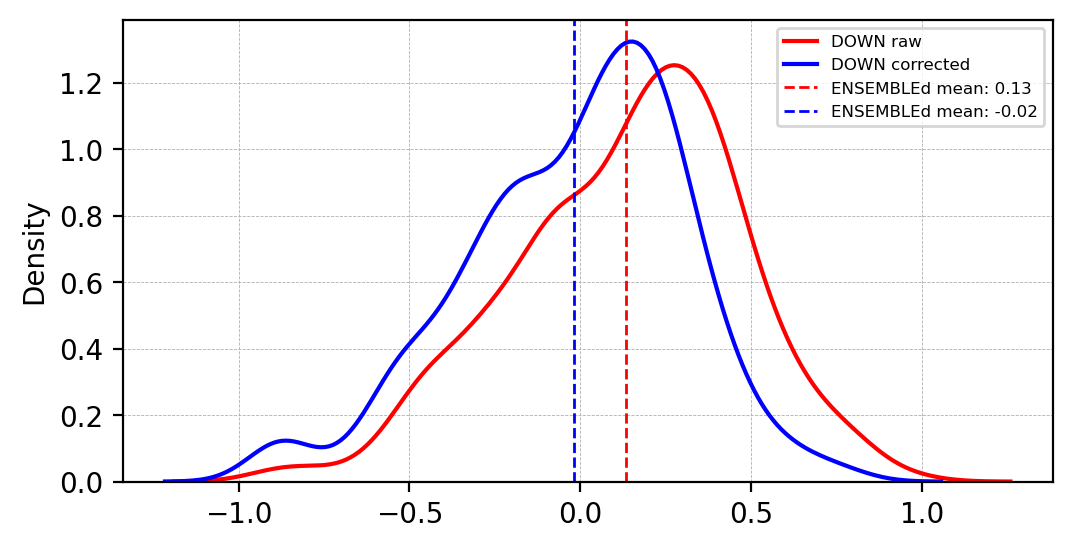

In [26]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(RE_down_raw.values.flatten(),color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'DOWN raw')
sns.kdeplot(RE_down_corrected.values.flatten(),color='b',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'DOWN corrected')

ax1.axvline(np.nanmean(RE_down_raw.values.flatten()),color='r',linestyle='--',linewidth=1, label=f'ENSEMBLEd mean: {np.round(np.nanmean(np.mean(np.nanmean(RE_down_raw.values.flatten()))),2)}')
ax1.axvline(np.nanmean(RE_down_corrected.values.flatten()),color='b',linestyle='--',linewidth=1, label=f'ENSEMBLEd mean: {np.round(np.nanmean(np.nanmean(RE_down_corrected.values.flatten())),2)}')

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize=6, loc=0, ncol=1)

In [50]:
ensemble_dir = os.path.join(os.path.join(dir_base, '6_DOWN_corrected', 'ITALY_ENSEMBLE_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc'))
DATA = xr.open_dataset(ensemble_dir)

lat_ensemble = DATA.lat.values
lon_ensemble = DATA.lon.values
lon2d_ens, lat2d_ens = np.meshgrid(lon_ensemble, lat_ensemble)

NYs_ens = DATA.NYs
CYs_ens = DATA.CYs
WYs_ens = DATA.WYs

NYd_ens = DATA.NYd
CYd_ens = DATA.CYd
WYd_ens = DATA.WYd

In [51]:
sat_dir = os.path.join(os.path.join(dir_base, '6_DOWN_corrected', 'ITALY_DOWN_CHIRPS_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc'))
DATA = xr.open_dataset(sat_dir)
lon2d_CH, lat2d_CH = np.meshgrid(DATA.lon, DATA.lat)
NYd_CH = DATA.NYd
CYd_CH = DATA.CYd
WYd_CH = DATA.WYd
RE_CH = export_STATISTICS(Q_20, NYd_CH, CYd_CH, WYd_CH, lat2d_CH, lon2d_CH)

In [52]:
sat_dir = os.path.join(os.path.join(dir_base, '6_DOWN_corrected', 'ITALY_DOWN_IMERG_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc'))
DATA = xr.open_dataset(sat_dir)
lon2d_IM, lat2d_IM = np.meshgrid(DATA.lon, DATA.lat)
NYd_IM = DATA.NYd
CYd_IM = DATA.CYd
WYd_IM = DATA.WYd
RE_IM = export_STATISTICS(Q_20, NYd_IM, CYd_IM, WYd_IM, lat2d_IM, lon2d_IM)

In [53]:
sat_dir = os.path.join(os.path.join(dir_base, '6_DOWN_corrected', 'ITALY_DOWN_MSWEP_3h_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc'))
DATA = xr.open_dataset(sat_dir)
lon2d_MS, lat2d_MS = np.meshgrid(DATA.lon, DATA.lat)
NYd_MS = DATA.NYd
CYd_MS = DATA.CYd
WYd_MS = DATA.WYd
RE_MS = export_STATISTICS(Q_20, NYd_MS, CYd_MS, WYd_MS, lat2d_MS, lon2d_MS)

In [54]:
sat_dir = os.path.join(os.path.join(dir_base, '6_DOWN_corrected', 'ITALY_DOWN_GSMaP_3h_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc'))
DATA = xr.open_dataset(sat_dir)
lon2d_GS, lat2d_GS = np.meshgrid(DATA.lon, DATA.lat)
NYd_GS = DATA.NYd
CYd_GS = DATA.CYd
WYd_GS = DATA.WYd
RE_GS = export_STATISTICS(Q_20, NYd_GS, CYd_GS, WYd_GS, lat2d_GS, lon2d_GS)

In [55]:
sat_dir = os.path.join(os.path.join(dir_base, '6_DOWN_corrected', 'ITALY_DOWN_ERA5_3h_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc'))
DATA = xr.open_dataset(sat_dir)
lon2d_ER, lat2d_ER = np.meshgrid(DATA.lon, DATA.lat)
NYd_ER = DATA.NYd
CYd_ER = DATA.CYd
WYd_ER = DATA.WYd
RE_ER = export_STATISTICS(Q_20, NYd_ER, CYd_ER, WYd_ER, lat2d_ER, lon2d_ER)

In [56]:
sat_dir = os.path.join(os.path.join(dir_base, '6_DOWN_corrected', 'ITALY_DOWN_CMORPH_3h_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc'))
DATA = xr.open_dataset(sat_dir)
lon2d_CM, lat2d_CM = np.meshgrid(DATA.lon, DATA.lat)
NYd_CM = DATA.NYd
CYd_CM = DATA.CYd
WYd_CM = DATA.WYd
RE_CM = export_STATISTICS(Q_20, NYd_CM, CYd_CM, WYd_CM, lat2d_CM, lon2d_CM)

In [57]:
RE_ensemble_Mevs = export_STATISTICS(Q_20, NYs_ens, CYs_ens, WYs_ens, lat2d_ens, lon2d_ens)
RE_ensemble_Mevd = export_STATISTICS(Q_20, NYd_ens, CYd_ens, WYd_ens, lat2d_ens, lon2d_ens)

In [58]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']

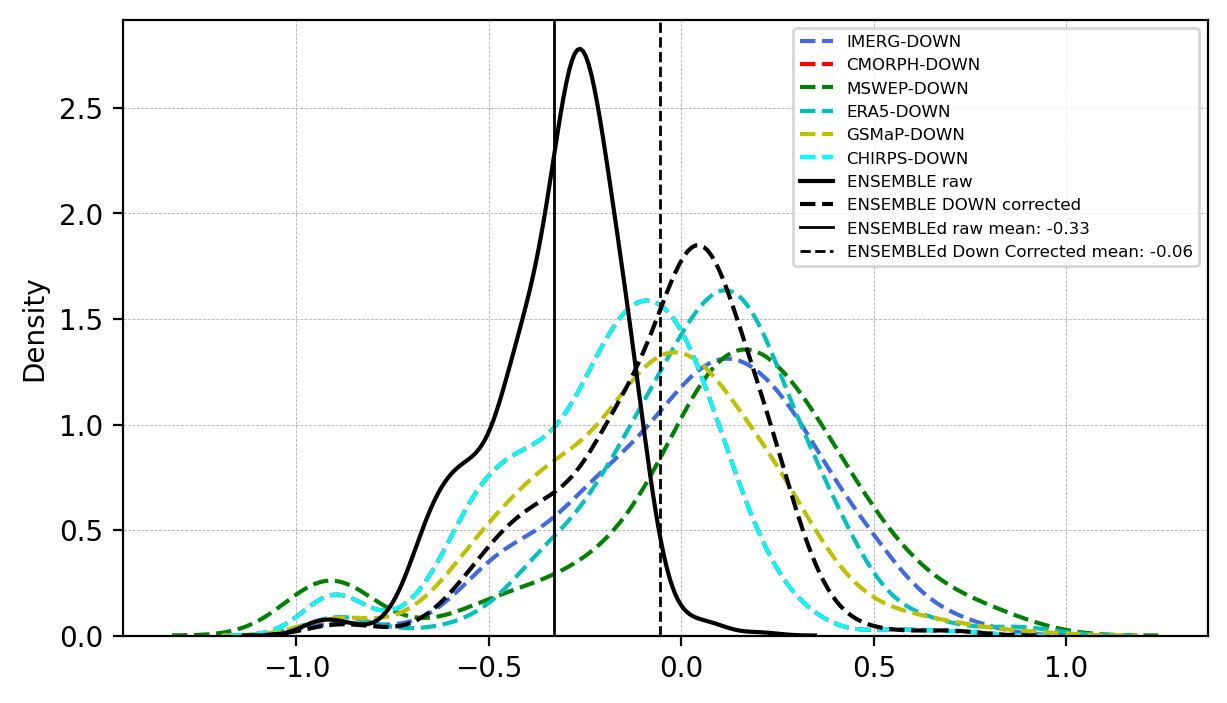

In [59]:
fig = plt.figure(figsize=(7,4),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(RE_IM.values.flatten(),color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG-DOWN')

sns.kdeplot(RE_CH.values.flatten(),color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH-DOWN')

sns.kdeplot(RE_MS.values.flatten(),color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP-DOWN')

sns.kdeplot(RE_ER.values.flatten(),color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5-DOWN')

sns.kdeplot(RE_GS.values.flatten(),color=colors[4], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP-DOWN')

sns.kdeplot(RE_CH.values.flatten(),color=colors[7], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPS-DOWN')

sns.kdeplot(RE_ensemble_Mevs.values.flatten(),color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE raw')
sns.kdeplot(RE_ensemble_Mevd.values.flatten(),color='k',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE DOWN corrected')

ax1.axvline(np.nanmean(RE_ensemble_Mevs.values.flatten()),color='k',linestyle='-',linewidth=1, label=f'ENSEMBLEd raw mean: {np.round(np.nanmean(np.mean(np.nanmean(RE_ensemble_Mevs.values.flatten()))),2)}')
ax1.axvline(np.nanmean(RE_ensemble_Mevd.values.flatten()),color='k',linestyle='--',linewidth=1, label=f'ENSEMBLEd Down Corrected mean: {np.round(np.nanmean(np.nanmean(RE_ensemble_Mevd.values.flatten())),2)}')

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize=6, loc=0, ncol=1)